<a href="https://colab.research.google.com/github/BankNatchapol/Comparison-of-Quantum-Gradient/blob/main/discrete_vs_continuous/discrete_gradient_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane-sf
!pip install qiskit
!pip install qiskit_optimization
!pip install -U kaleido

In [ ]:
import pennylane as qml
from pennylane import numpy as np

from pandas.plotting import table 
import pandas as pd
import time 

import networkx as nx
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objects as go
import plotly.express as px

from docplex.mp.model import Model
from qiskit.opflow import Z, X, Y, I
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.applications import Maxcut, Clique, Knapsack
from qiskit_optimization.converters import QuadraticProgramToQubo

In [ ]:
#@title Auxilary Function
def Had(wires):
  qml.RY(np.pi/2, wires=wires)
  qml.RX(np.pi, wires=wires)


def fully_connected_layer(num_wires):
  if num_wires>1:
    for wire in range(num_wires-1):
      qml.CNOT(wires=[wire, wire+1])
    qml.CNOT(wires=[wire+1, 0])

def str2gate(gate):
  if gate == 'H':
    return Had
  elif gate == 'X':
    return qml.PauliX
  elif gate == 'Y':
    return qml.PauliY
  elif gate == 'Z':
    return qml.PauliZ
  elif gate == 'RX':
    return qml.RX
  elif gate == 'RY':
    return qml.RY
  elif gate == 'RZ':
    return qml.RZ
  else:
    assert 0, "Gate not support."

def controlStr(gate):
  if gate == 'RX':
    return qml.CNOT
  elif gate == 'RY':
    return qml.CY
  elif gate == 'RZ':
    return qml.CZ
  else:
    assert 0, "Gate not support."
    
def hamiltonian_from_qiskit(sum_op):

	'''
	This function takes a qiskit.PauliSumOp as input and
	gives back a Pennylane Hamiltonian as output

	sum_op  = qiskit.PauliSumOp

	'''
	op      = sum_op.primitive.to_list()
	n_terms = len(op)
	coeffs  = []
	paulis  = []

	for i in range(n_terms):
		paulis.append(qml.grouping.string_to_pauli_word("".join(list(reversed(op[i][0])))))
		coeffs.append(op[i][1].real)

	p_op = qml.Hamiltonian(coeffs,paulis)

	return p_op

def hamiltonian_from_qiskit_lcu(sum_op):

  '''
  This function takes a qiskit.PauliSumOp as input and
  gives back a Pennylane Hamiltonian as output

  sum_op  = qiskit.PauliSumOp

  '''
  op      = sum_op.primitive.to_list()
  n_terms = len(op)
  coeffs  = []
  paulis  = []

  for i in range(n_terms):
    if op[i][0]=="I":
      paulis.append(qml.grouping.string_to_pauli_word("".join(list(reversed(op[i][0])))))
    else:
      paulis.append(qml.grouping.string_to_pauli_word("".join(list(reversed(op[i][0])))+"Z"))
    coeffs.append(op[i][1].real)

  p_op = qml.Hamiltonian(coeffs,paulis)

  return p_op

def get_adjacency_matrix(elist):
  adjacency_matrix = np.zeros([num_wires, num_wires])

  for i,j in elist:
    adjacency_matrix[i, j] = 1.0
    adjacency_matrix[j, i] = 1.0

  return adjacency_matrix

def draw_graph(elist, colors):
  G = nx.Graph()
  #G.add_nodes_from(np.arange(0, n, 1))
  # tuple is (i,j,weight) where (i,j) is the edge
  G.add_edges_from(elist)
  pos = nx.spring_layout(G)
  default_axes = plt.axes(frameon=True)
  nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)

def int_to_binary(value, size):
  """Function that converts an integer to a binary string."""

  bi = "{0:b}".format(value)
  if len(bi)<size:
    bi = "0"*(size-len(bi)) + bi
  return bi

# **Gradient methods**

## Discrete-variable

### Parameter shift rule

In [ ]:
def parameter_shift_term(qnode, params, i, j):

    shifted = params.copy()
    
    shifted[i, j] += np.pi/2
    forward = qnode(shifted)  # forward evaluation

    shifted[i, j] -= np.pi
    backward = qnode(shifted) # backward evaluation

    return 0.5 * (forward - backward)

def parameter_shift(qnode, params):
    gradients = np.zeros_like((params))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):
            gradients[i, j] += parameter_shift_term(qnode, params, i, j)

    return gradients

### Finite difference

In [ ]:
def finite_term(qnode, params, i, j):
    
    eps = 0.01

    shifted = params.copy()
    
    shifted[i, j] += eps
    forward = qnode(shifted)  # forward evaluation

    shifted[i, j] -= 2*eps
    backward = qnode(shifted) # backward evaluation

    return (1/(2*eps)) * (forward - backward)

def finite_difference(qnode, params):
    gradients = np.zeros_like((params))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):
            gradients[i, j] += finite_term(qnode, params, i, j)

    return gradients

### Linear combination of unitaries (LCU)

In [ ]:
param_gates = ['RX', 'RY', 'RZ']

def lcu_term(ansatz, params, wires, diff_index, num_wires, num_layers):
  qml.Hadamard(wires=num_wires)
  break_point = len(ansatz)//num_layers
  qml.adjoint(qml.S)(wires=num_wires)

  counting = 0
  for i, gate in enumerate(ansatz):
    
    if gate in param_gates:
      if i == diff_index:
        controlStr(gate)(wires=[num_wires, (diff_index//4)%4])
      str2gate(gate)(params[counting], wires=wires[i])
      counting += 1
    else:
      str2gate(gate)(wires=wires[i])
    if i!=0 and (i+1)%break_point==0:
      fully_connected_layer(num_wires)
  qml.Hadamard(wires=num_wires)

def lcu_gradients(ansatz_label, H, params):
  num_layers = len(params)
  num_wires = len(H.wires)-1
  num_param_gates = len(params[0])//num_wires

  ansatz = ansatz_label * num_layers * num_wires
  
  wires = []
  for i in range(num_layers):
    for j in range(num_wires):
      for k in range(4):
        wires.append(j)
  params = params.flatten()

  dev = qml.device("default.qubit", wires=num_wires+1)
  @qml.qnode(dev)
  def lcu(ansatz, H, params, wires, diff_index):
    
    lcu_term(ansatz, params, wires, diff_index, num_wires, num_layers)
    
    return qml.expval(H)

  gradients = []
  for i in range(len(ansatz)):
    if ansatz[i] in param_gates:
      gradients.append(lcu(ansatz, H, params, wires, i))
      
  return np.array(gradients).reshape(num_layers, -1)

### Quantum natural gradient (QNG)

In [ ]:
def quantum_natural_gradient(var, H, cost_function):
  num_wires = len(H.wires)
  dev = qml.device('default.qubit', wires=num_wires)

  @qml.qnode(dev)
  def metric_tensor_circuit(var):
    for v in var: 
      ansatz(v, num_wires)
    return qml.expval(H)

  metric_fn = qml.metric_tensor(metric_tensor_circuit, approx="block-diag", hybrid=False)
  grad = parameter_shift(cost_function, var)
  grad_flatten = grad.flatten()
  metric_tensor = metric_fn(var)
  reg = 1e-7
  iden = np.identity(len(metric_tensor))*reg
  metric_tensor += iden
  qng_grad = np.linalg.solve(metric_tensor, grad_flatten)

  return qng_grad


### Quantum newton gradient

In [ ]:
def newton_gradient(cost_function, H, params, reg=2):
  num_layers = len(params)
  params_ori = params.copy()
  params = params.reshape(1,-1)[0]
  num_wires = len(H.wires)
  dev = qml.device('default.qubit', wires=num_wires)

  def ansatz_newton(var, num_wires):
    for l in range(num_layers):
      for wire in range(num_wires):
        qml.Hadamard(wires=wire)
        qml.RX(var[0+3*wire + l*3*num_wires], wires=wire)
        qml.RY(var[1+3*wire+ l*3*num_wires], wires=wire)
        qml.RZ(var[2+3*wire+ l*3*num_wires], wires=wire)
      fully_connected_layer(num_wires)

  @qml.qnode(dev)
  def circuit(var, H):
    ansatz_newton(var, num_wires)
    return qml.expval(H)
    
  grad_fn = qml.grad(circuit)
  hes_fn = qml.jacobian(grad_fn)
  grad = parameter_shift(lambda x: cost_function(x, H), params_ori).flatten()
  hessian_matrix = hes_fn(params, H)
  iden = np.identity(len(hessian_matrix))*reg
  hessian_matrix += iden
  
  newton_grad = np.linalg.solve(hessian_matrix, grad)

  return newton_grad.reshape(num_layers,-1)
  

## Continuous-variable

### Parameter shift rule

In [ ]:
# gate_list = ['R', 'S1', 'D1']

# def parameter_shift_cv_term(qnode, params, i, j):
    
#     gate = gate_list[j%len(gate_list)]

#     shifted = params.copy()

#     if gate == 'R' or gate == 'S2' or gate == 'D2':
#       shifted[i, j] += alpha
#       forward = qnode(shifted)  # forward evaluation

#       shifted[i, j] -= 2*alpha
#       backward = qnode(shifted) # backward evaluation

#       return (1/2) * (forward - backward)

#     elif gate == 'S1':
#       shifted[i, j] += s
#       forward = qnode(shifted)  # forward evaluation

#       shifted[i, j] -= 2*s
#       backward = qnode(shifted) # backward evaluation

#       return (1/(2*np.sinh(s))) * (forward - backward)
    
#     elif gate == 'D1':
#       shifted[i, j] += s
#       forward = qnode(shifted)  # forward evaluation

#       shifted[i, j] -= 2*s
#       backward = qnode(shifted) # backward evaluation

#       return (1/(2*s)) * (forward - backward)

# def parameter_shift_cv(qnode, params):
#     gradients = np.zeros_like((params))
#     for i in range(len(gradients)):
#         for j in range(len(gradients[0])):
#             gradients[i, j] += parameter_shift_cv_term(qnode, params, i, j)

#     return gradients

### Finite difference

In [ ]:
# def finite_cv_term(qnode, params, i, j):
    
#     eps = 0.01

#     shifted = params.copy()
    
#     shifted[i, j] += eps
#     forward = qnode(shifted)  # forward evaluation

#     shifted[i, j] -= 2*eps
#     backward = qnode(shifted) # backward evaluation

#     return (1/(2*eps)) * (forward - backward)

# def finite_difference_cv(qnode, params):
#     gradients = np.zeros_like((params))
#     for i in range(len(gradients)):
#         for j in range(len(gradients[0])):
#             gradients[i, j] += finite_cv_term(qnode, params, i, j)

#     return gradients

# **Problem Fomulation** 

## Max-Cut

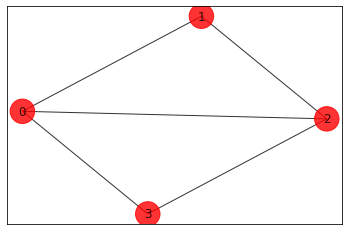

In [ ]:
num_wires = 4  # Number of nodes in graph

elist_maxcut = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]
colors_maxcut = ["r" for node in range(num_wires)]

draw_graph(elist_maxcut, colors_maxcut)

In [ ]:
adjacency_matrix_maxcut = get_adjacency_matrix(elist_maxcut)
max_cut = Maxcut(adjacency_matrix_maxcut)
qp_maxcut = max_cut.to_quadratic_program()
print(qp_maxcut.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 3 x_0 + 2 x_1 + 3 x_2 + 2 x_3 + [ - 4 x_0*x_1 - 4 x_0*x_2 - 4 x_0*x_3
      - 4 x_1*x_2 - 4 x_2*x_3 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



In [ ]:
qubitOp_maxcut, offset_maxcut = qp_maxcut.to_ising()
H_maxcut = hamiltonian_from_qiskit(qubitOp_maxcut)
H_maxcut_lcu = hamiltonian_from_qiskit_lcu(qubitOp_maxcut)
print("Offset:", offset_maxcut,"\n")
print("Ising Hamiltonian:\n")

print(H_maxcut)

Offset: -2.5 

Ising Hamiltonian:

  (0.5) [Z2 Z3]
+ (0.5) [Z1 Z2]
+ (0.5) [Z0 Z3]
+ (0.5) [Z0 Z2]
+ (0.5) [Z0 Z1]


## Clique

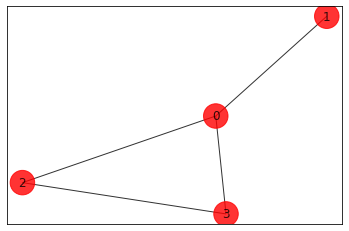

In [ ]:
num_wires = 4  # Number of nodes in graph

elist_clique = [(0, 1), (0, 2), (0, 3), (2, 3)]
colors_clique = ["r" for node in range(num_wires)]

draw_graph(elist_clique, colors_clique)

In [ ]:
adjacency_matrix_clique = get_adjacency_matrix(elist_clique)
clique = Clique(adjacency_matrix_clique)
qp_clique = clique.to_quadratic_program()
print(qp_clique.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Clique

Maximize
 obj: x_0 + x_1 + x_2 + x_3
Subject To
 c0: x_1 + x_2 <= 1
 c1: x_1 + x_3 <= 1

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



In [ ]:
qp2qubo = QuadraticProgramToQubo()
qubo_clique = qp2qubo.convert(qp_clique)

qubitOp_clique, offset_clique = qubo_clique.to_ising()
H_clique = hamiltonian_from_qiskit(qubitOp_clique)
H_clique_lcu = hamiltonian_from_qiskit_lcu(qubitOp_clique)

print("Offset:", offset_clique,"\n")
print("Ising Hamiltonian:\n")

print(H_clique)

Offset: 0.5 

Ising Hamiltonian:

  (-2.0) [Z1]
+ (-0.75) [Z3]
+ (-0.75) [Z2]
+ (0.5) [Z0]
+ (1.25) [Z1 Z3]
+ (1.25) [Z1 Z2]


## Binary Linear Programming

In [ ]:
blp = Model("docplex model")
x1 = blp.binary_var("x1")
x2 = blp.binary_var("x2")
x3 = blp.binary_var("x3")
x4 = blp.binary_var("x4")

blp.minimize(195000*x1 + 96000*x2 + 87000*x3 + 120000*x4)
blp.add_constraint(x1  + x3 >= 1)
blp.add_constraint(x2 + x4 >= 1)

# load from a Docplex model
qp_blp = from_docplex_mp(blp)
print(qp_blp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: 195000 x1 + 96000 x2 + 87000 x3 + 120000 x4
Subject To
 c0: x1 + x3 >= 1
 c1: x2 + x4 >= 1

Bounds
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x1 x2 x3 x4
End



In [ ]:
qubo_blp = qp2qubo.convert(qp_blp)

qubitOp_blp, offset_blp = qubo_blp.to_ising()
H_blp = hamiltonian_from_qiskit(qubitOp_blp)
H_blp_lcu = hamiltonian_from_qiskit_lcu(qubitOp_blp)

print("Offset:", offset_blp,"\n")
print("Ising Hamiltonian:\n")

print(H_blp)

Offset: 498000.5 

Ising Hamiltonian:

  (27000.25) [Z0]
+ (64500.25) [Z3]
+ (76500.25) [Z1]
+ (81000.25) [Z2]
+ (124500.25) [Z1 Z3]
+ (124500.25) [Z0 Z2]


## Knapsack

In [ ]:
weights = [1, 2]
profits = [2, 1]
max_weight = 3
knapsack = Knapsack(profits, weights, max_weight)
qp_ks = knapsack.to_quadratic_program()
print(qp_ks.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Maximize
 obj: 2 x_0 + x_1
Subject To
 c0: x_0 + 2 x_1 <= 3

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1

Binaries
 x_0 x_1
End



In [ ]:
qubo_ks = qp2qubo.convert(qp_ks)

qubitOp_ks, offset_ks = qubo_ks.to_ising()
H_ks = hamiltonian_from_qiskit(qubitOp_ks)
H_ks_lcu = hamiltonian_from_qiskit_lcu(qubitOp_ks)

print("Offset:", offset_ks,"\n")
print("Ising Hamiltonian:\n")

print(H_ks)

Offset: 8.5 

Ising Hamiltonian:

  (0.5) [Z1]
+ (1.0) [Z0]
+ (2.0) [Z0 Z2]
+ (4.0) [Z2 Z3]
+ (4.0) [Z1 Z2]
+ (4.0) [Z0 Z3]
+ (4.0) [Z0 Z1]
+ (8.0) [Z1 Z3]


# **Optimization**

## Discrete-variable

In [ ]:
# guesting ansatz state

ansatz_label = ['H', 'RX', 'RY', 'RZ'] 

def ansatz(var, num_wires):
    for wire in range(num_wires):
      qml.Hadamard(wires=wire)
      qml.RX(var[0+3*wire], wires=wire)
      qml.RY(var[1+3*wire], wires=wire)
      qml.RZ(var[2+3*wire], wires=wire)
    fully_connected_layer(num_wires)

In [ ]:
def cost_function(var, H):
  num_wires = len(H.wires)
  dev = qml.device('default.qubit', wires=num_wires)

  @qml.qnode(dev)
  def circuit(var, H):
    for v in var: 
      ansatz(v, num_wires)
    return qml.expval(H)

  return circuit(var, H)

Probability distribution of estimated gate 

In [ ]:
# prediction circuit
def prediction(var, num_param_gates):
  num_wires = len(var[0])//num_param_gates
  dev = qml.device('default.qubit', wires=num_wires)
  @qml.qnode(dev)
  def circuit(var):
    for v in var: 
      ansatz(v, num_wires)
    return qml.probs(wires=range(num_wires))  # get prediction probability
  
  state = circuit(var)
  result = np.argmax(state)
  return int_to_binary(result, num_wires)[::-1]

In [ ]:
np.random.seed(1)
num_layers = 2
num_param_gates = 3

var_init_maxcut = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))
var_init_clique = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))
var_init_blp = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))
var_init_ks = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

steps = [2, 4, 6, 8, 10]

In [ ]:
print("Initial cost: ", cost_function(var_init_maxcut, H_maxcut)+offset_maxcut)

Initial cost:  -1.7157690662825986


In [ ]:
print("Prediction: ", prediction(var_init_maxcut, num_param_gates))

Prediction:  0000


Function for training optimizer

In [ ]:
def train(cost_fn, grad_fn, epochs, var_init, lr):
  lost_list = []
  time_list = []

  var = var_init.copy()

  opt = qml.RMSPropOptimizer(lr)

  start = time.time()

  for it in range(epochs):# while True:
      var, _cost = opt.step_and_cost(cost_fn, var, grad_fn=grad_fn) 
      lost_list.append(_cost.numpy())

      if it%10==0:
        print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))

      end = time.time()
      t = end - start
      time_list.append(t)

  return lost_list, time_list, var

Varaible List

In [ ]:
# lost list
psl = []
fdl = []
lcul = []
qngl = []
qnwl = []

# time list
pst = []
fdt = []
lcut = []
qngt = []
qnwt = []


# lost list change num layer
pslc = []
fdlc = []
lculc = []
qnglc = []
qnwlc = []

# time list change num layer
pstc = []
fdtc = []
lcutc = []
qngtc = []
qnwtc = []

### Parameter Shift Rule

#### Max-Cut

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_maxcut), var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)
psl.append(lost_list)
pst.append(time_list)

Iter:     0 | Cost: -1.71576906628 
Iter:    10 | Cost: -2.92916432842 
Iter:    20 | Cost: -3.11048527652 
Iter:    30 | Cost: -3.34736042978 
Iter:    40 | Cost: -3.48595961977 
Iter:    50 | Cost: -3.49983208406 
Iter:    60 | Cost: -3.49999990501 
Iter:    70 | Cost: -3.49999947768 
Iter:    80 | Cost: -3.49423438483 
Iter:    90 | Cost: -3.49956678195 
Iter:   100 | Cost: -3.49925734176 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))

  cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
  grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_maxcut), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

pslc.append(temp1)
pstc.append(temp2)

Iter:     0 | Cost: -1.71576906628 
Iter:    10 | Cost: -2.92916432842 
Iter:     0 | Cost: -1.89311957074 
Iter:    10 | Cost: -3.53930104842 
Iter:     0 | Cost: -2.03814866340 
Iter:    10 | Cost: -3.82823170950 
Iter:     0 | Cost: -2.44119325891 
Iter:    10 | Cost: -3.78783720610 
Iter:     0 | Cost: -2.72776845307 
Iter:    10 | Cost: -3.93299095537 


#### Clique

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_clique), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
psl.append(lost_list)
pst.append(time_list)

Iter:     0 | Cost: 0.12889348726 
Iter:    10 | Cost: -1.94362101683 
Iter:    20 | Cost: -2.34559567383 
Iter:    30 | Cost: -2.45196028842 
Iter:    40 | Cost: -2.48354286450 
Iter:    50 | Cost: -2.49451567238 
Iter:    60 | Cost: -2.49839653114 
Iter:    70 | Cost: -2.49478568494 
Iter:    80 | Cost: -2.49799505377 
Iter:    90 | Cost: -2.49835671272 
Iter:   100 | Cost: -2.49815187014 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))

  cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
  grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_clique), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

pslc.append(temp1)
pstc.append(temp2)

Iter:     0 | Cost: -0.32878854620 
Iter:    10 | Cost: -1.87686385822 
Iter:     0 | Cost: -0.62011189961 
Iter:    10 | Cost: -2.40720219177 
Iter:     0 | Cost: 1.03736341873 
Iter:    10 | Cost: -2.63585339362 
Iter:     0 | Cost: 0.69824350827 
Iter:    10 | Cost: -2.78925391167 
Iter:     0 | Cost: 1.96240124826 
Iter:    10 | Cost: -2.65025204862 


#### Binary Linear Programming

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_blp), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
psl.append(lost_list)
pst.append(time_list)

Iter:     0 | Cost: 667294.31366741285 
Iter:    10 | Cost: 380039.14750654984 
Iter:    20 | Cost: 306427.84090514830 
Iter:    30 | Cost: 257869.31339366946 
Iter:    40 | Cost: 213104.50375085504 
Iter:    50 | Cost: 189464.36864009284 
Iter:    60 | Cost: 183724.44258928957 
Iter:    70 | Cost: 183028.39590268570 
Iter:    80 | Cost: 183000.09582436603 
Iter:    90 | Cost: 183000.45272810874 
Iter:   100 | Cost: 183011.13886463881 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))

  cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
  grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_blp), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

pslc.append(temp1)
pstc.append(temp2)

Iter:     0 | Cost: 631720.31831967935 
Iter:    10 | Cost: 314801.59237132076 
Iter:     0 | Cost: 659107.38464029436 
Iter:    10 | Cost: 285518.82152659062 
Iter:     0 | Cost: 601268.39232154237 
Iter:    10 | Cost: 233156.36877137632 
Iter:     0 | Cost: 416790.04523771151 
Iter:    10 | Cost: 194202.64663859428 
Iter:     0 | Cost: 445969.56532474287 
Iter:    10 | Cost: 217817.13097259385 


#### Knapsack

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_ks), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
psl.append(lost_list)
pst.append(time_list)

Iter:     0 | Cost: 27.69312856107 
Iter:    10 | Cost: 5.54870502942 
Iter:    20 | Cost: 3.09184860769 
Iter:    30 | Cost: 0.91336450593 
Iter:    40 | Cost: -1.70638927527 
Iter:    50 | Cost: -2.75645495037 
Iter:    60 | Cost: -2.96160359888 
Iter:    70 | Cost: -2.99657026131 
Iter:    80 | Cost: -2.99991661554 
Iter:    90 | Cost: -2.99999933457 
Iter:   100 | Cost: -2.99999999960 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

  cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
  grad_fn = lambda var: parameter_shift(lambda x: cost_function(x, H_ks), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

pslc.append(temp1)
pstc.append(temp2)

Iter:     0 | Cost: 16.08365820085 
Iter:    10 | Cost: 2.24360521907 
Iter:     0 | Cost: 15.75963494829 
Iter:    10 | Cost: -0.20698997864 
Iter:     0 | Cost: 14.88568424087 
Iter:    10 | Cost: 0.18794862926 
Iter:     0 | Cost: 7.31937591142 
Iter:    10 | Cost: -0.99668318014 
Iter:     0 | Cost: 7.32230064599 
Iter:    10 | Cost: -1.77927028829 


### Finite Difference

#### Max-Cut

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_maxcut), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)
fdl.append(lost_list)
fdt.append(time_list)

Iter:     0 | Cost: -1.71576906628 
Iter:    10 | Cost: -2.92916432842 
Iter:    20 | Cost: -3.11048527652 
Iter:    30 | Cost: -3.34736042977 
Iter:    40 | Cost: -3.48595961977 
Iter:    50 | Cost: -3.49983208406 
Iter:    60 | Cost: -3.49999990480 
Iter:    70 | Cost: -3.49999947244 
Iter:    80 | Cost: -3.49423034186 
Iter:    90 | Cost: -3.49956528291 
Iter:   100 | Cost: -3.49925844678 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))

  cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
  grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_maxcut), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

fdlc.append(temp1)
fdtc.append(temp2)

Iter:     0 | Cost: -1.71576906628 
Iter:    10 | Cost: -2.92916432842 
Iter:     0 | Cost: -1.89311957074 
Iter:    10 | Cost: -3.53930104627 
Iter:     0 | Cost: -2.03814866340 
Iter:    10 | Cost: -3.82823171135 
Iter:     0 | Cost: -2.44119325891 
Iter:    10 | Cost: -3.78783736751 
Iter:     0 | Cost: -2.72776845307 
Iter:    10 | Cost: -3.93299095587 


#### Clique

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_clique), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
fdl.append(lost_list)
fdt.append(time_list)

Iter:     0 | Cost: 0.12889348726 
Iter:    10 | Cost: -1.94362101686 
Iter:    20 | Cost: -2.34559567384 
Iter:    30 | Cost: -2.45196028842 
Iter:    40 | Cost: -2.48354286474 
Iter:    50 | Cost: -2.49451567217 
Iter:    60 | Cost: -2.49839653132 
Iter:    70 | Cost: -2.49478568717 
Iter:    80 | Cost: -2.49799505336 
Iter:    90 | Cost: -2.49835671269 
Iter:   100 | Cost: -2.49815187030 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))

  cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
  grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_clique), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

fdlc.append(temp1)
fdtc.append(temp2)

Iter:     0 | Cost: -0.32878854620 
Iter:    10 | Cost: -1.87686383554 
Iter:     0 | Cost: -0.62011189961 
Iter:    10 | Cost: -2.40720219150 
Iter:     0 | Cost: 1.03736341873 
Iter:    10 | Cost: -2.63585339360 
Iter:     0 | Cost: 0.69824350827 
Iter:    10 | Cost: -2.78925386359 
Iter:     0 | Cost: 1.96240124826 
Iter:    10 | Cost: -2.65025204880 


#### Binary Linear Programming

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_blp), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
fdl.append(lost_list)
fdt.append(time_list)

Iter:     0 | Cost: 667294.31366741285 
Iter:    10 | Cost: 380039.14750654961 
Iter:    20 | Cost: 306427.84090514854 
Iter:    30 | Cost: 257869.31339367171 
Iter:    40 | Cost: 213104.50375085883 
Iter:    50 | Cost: 189464.36864009482 
Iter:    60 | Cost: 183724.44258929009 
Iter:    70 | Cost: 183028.39590268576 
Iter:    80 | Cost: 183000.09588815260 
Iter:    90 | Cost: 183000.39324232360 
Iter:   100 | Cost: 183252.49390157545 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))

  cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
  grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_blp), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

fdlc.append(temp1)
fdtc.append(temp2)

Iter:     0 | Cost: 631720.31831967935 
Iter:    10 | Cost: 314801.59237132064 
Iter:     0 | Cost: 659107.38464029436 
Iter:    10 | Cost: 285518.82152658893 
Iter:     0 | Cost: 601268.39232154237 
Iter:    10 | Cost: 233156.36877137795 
Iter:     0 | Cost: 416790.04523771151 
Iter:    10 | Cost: 194202.64663859486 
Iter:     0 | Cost: 445969.56532474287 
Iter:    10 | Cost: 217817.13097259722 


#### Knapsack

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_ks), var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
fdl.append(lost_list)
fdt.append(time_list)

Iter:     0 | Cost: 27.69312856107 
Iter:    10 | Cost: 5.54870502943 
Iter:    20 | Cost: 3.09184860769 
Iter:    30 | Cost: 0.91336450595 
Iter:    40 | Cost: -1.70638927526 
Iter:    50 | Cost: -2.75645495037 
Iter:    60 | Cost: -2.96160359888 
Iter:    70 | Cost: -2.99657026131 
Iter:    80 | Cost: -2.99991661554 
Iter:    90 | Cost: -2.99999933457 
Iter:   100 | Cost: -2.99999999835 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

  cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
  grad_fn = lambda var: finite_difference(lambda x: cost_function(x, H_ks), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

fdlc.append(temp1)
fdtc.append(temp2)

Iter:     0 | Cost: 16.08365820085 
Iter:    10 | Cost: 2.24360521907 
Iter:     0 | Cost: 15.75963494829 
Iter:    10 | Cost: -0.20698997864 
Iter:     0 | Cost: 14.88568424087 
Iter:    10 | Cost: 0.18794863023 
Iter:     0 | Cost: 7.31937591142 
Iter:    10 | Cost: -0.99668319856 
Iter:     0 | Cost: 7.32230064599 
Iter:    10 | Cost: -1.77927028886 


### Linear combination of unitaries (LCU)

#### Max-Cut

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
grad_fn = lambda var: lcu_gradients(ansatz_label, H_maxcut_lcu, var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)
lcul.append(lost_list)
lcut.append(time_list)

Iter:     0 | Cost: -1.71576906628 
Iter:    10 | Cost: -2.92916432842 
Iter:    20 | Cost: -3.11048527652 
Iter:    30 | Cost: -3.34736042978 
Iter:    40 | Cost: -3.48595961977 
Iter:    50 | Cost: -3.49983208406 
Iter:    60 | Cost: -3.49999990501 
Iter:    70 | Cost: -3.49999947778 
Iter:    80 | Cost: -3.49423442491 
Iter:    90 | Cost: -3.49956681741 
Iter:   100 | Cost: -3.49925731642 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))
  cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
  grad_fn = lambda var: lcu_gradients(ansatz_label, H_maxcut_lcu, var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

lculc.append(temp1)
lcutc.append(temp2)

Iter:     0 | Cost: -1.71576906628 
Iter:    10 | Cost: -2.92916432842 
Iter:     0 | Cost: -1.89311957074 
Iter:    10 | Cost: -3.53930104842 
Iter:     0 | Cost: -2.03814866340 
Iter:    10 | Cost: -3.82823170950 
Iter:     0 | Cost: -2.44119325891 
Iter:    10 | Cost: -3.78783720610 
Iter:     0 | Cost: -2.72776845307 
Iter:    10 | Cost: -3.93299095537 


#### Clique

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
grad_fn = lambda var: lcu_gradients(ansatz_label, H_clique_lcu, var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
lcul.append(lost_list)
lcut.append(time_list)

Iter:     0 | Cost: 0.12889348726 
Iter:    10 | Cost: -1.94362101683 
Iter:    20 | Cost: -2.34559567383 
Iter:    30 | Cost: -2.45196028842 
Iter:    40 | Cost: -2.48354286450 
Iter:    50 | Cost: -2.49451567238 
Iter:    60 | Cost: -2.49839653114 
Iter:    70 | Cost: -2.49478568495 
Iter:    80 | Cost: -2.49799505377 
Iter:    90 | Cost: -2.49835671272 
Iter:   100 | Cost: -2.49815187014 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))

  cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
  grad_fn = lambda var: lcu_gradients(ansatz_label, H_clique_lcu, var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

lculc.append(temp1)
lcutc.append(temp2)

Iter:     0 | Cost: -0.32878854620 
Iter:    10 | Cost: -1.87686385822 
Iter:     0 | Cost: -0.62011189961 
Iter:    10 | Cost: -2.40720219177 
Iter:     0 | Cost: 1.03736341873 
Iter:    10 | Cost: -2.63585339362 
Iter:     0 | Cost: 0.69824350827 
Iter:    10 | Cost: -2.78925391167 
Iter:     0 | Cost: 1.96240124826 
Iter:    10 | Cost: -2.65025204862 


#### Binary Linear Programming

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
grad_fn = lambda var: lcu_gradients(ansatz_label, H_blp_lcu, var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
lcul.append(lost_list)
lcut.append(time_list)

Iter:     0 | Cost: 667294.31366741285 
Iter:    10 | Cost: 380039.14750654978 
Iter:    20 | Cost: 306427.84090514819 
Iter:    30 | Cost: 257869.31339366932 
Iter:    40 | Cost: 213104.50375085528 
Iter:    50 | Cost: 189464.36864009302 
Iter:    60 | Cost: 183724.44258928933 
Iter:    70 | Cost: 183028.39590268594 
Iter:    80 | Cost: 183000.09582122671 
Iter:    90 | Cost: 183001.76578554459 
Iter:   100 | Cost: 183005.17231672612 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))

  cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
  grad_fn = lambda var: lcu_gradients(ansatz_label, H_blp_lcu, var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

lculc.append(temp1)
lcutc.append(temp2)

Iter:     0 | Cost: 631720.31831967935 
Iter:    10 | Cost: 314801.59237132064 
Iter:     0 | Cost: 659107.38464029436 
Iter:    10 | Cost: 285518.82152659062 
Iter:     0 | Cost: 601268.39232154237 
Iter:    10 | Cost: 233156.36877137632 
Iter:     0 | Cost: 416790.04523771151 
Iter:    10 | Cost: 194202.64663859439 
Iter:     0 | Cost: 445969.56532474287 
Iter:    10 | Cost: 217817.13097259443 


#### Knapsack

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
grad_fn = lambda var: lcu_gradients(ansatz_label, H_ks_lcu, var)
lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
lcul.append(lost_list)
lcut.append(time_list)

Iter:     0 | Cost: 27.69312856107 
Iter:    10 | Cost: 5.54870502942 
Iter:    20 | Cost: 3.09184860769 
Iter:    30 | Cost: 0.91336450593 
Iter:    40 | Cost: -1.70638927527 
Iter:    50 | Cost: -2.75645495037 
Iter:    60 | Cost: -2.96160359888 
Iter:    70 | Cost: -2.99657026131 
Iter:    80 | Cost: -2.99991661554 
Iter:    90 | Cost: -2.99999933457 
Iter:   100 | Cost: -2.99999999960 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

  cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
  grad_fn = lambda var: lcu_gradients(ansatz_label, H_ks_lcu, var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

lculc.append(temp1)
lcutc.append(temp2)

Iter:     0 | Cost: 16.08365820085 
Iter:    10 | Cost: 2.24360521907 
Iter:     0 | Cost: 15.75963494829 
Iter:    10 | Cost: -0.20698997864 
Iter:     0 | Cost: 14.88568424087 
Iter:    10 | Cost: 0.18794862926 
Iter:     0 | Cost: 7.31937591142 
Iter:    10 | Cost: -0.99668318014 
Iter:     0 | Cost: 7.32230064599 
Iter:    10 | Cost: -1.77927028829 


### Quantum natural gradient (QNG)

#### Max-Cut

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
grad_fn = lambda var: quantum_natural_gradient(var, H_maxcut, lambda x: cost_function(x, H_maxcut))
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)
qngl.append(lost_list)
qngt.append(time_list)

Iter:     0 | Cost: -1.71576906628 
Iter:    10 | Cost: -2.94158928907 
Iter:    20 | Cost: -3.13068319439 
Iter:    30 | Cost: -3.36294601610 
Iter:    40 | Cost: -3.48846869402 
Iter:    50 | Cost: -3.49989231938 
Iter:    60 | Cost: -3.49999996582 
Iter:    70 | Cost: -3.49999800734 
Iter:    80 | Cost: -3.49821005695 
Iter:    90 | Cost: -3.49992934320 
Iter:   100 | Cost: -3.49762853222 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))

  cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
  grad_fn = lambda var: quantum_natural_gradient(var, H_maxcut, lambda x: cost_function(x, H_maxcut))
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnglc.append(temp1)
qngtc.append(temp2)

Iter:     0 | Cost: -1.71576906628 
Iter:    10 | Cost: -2.94158928907 
Iter:     0 | Cost: -1.89311957074 
Iter:    10 | Cost: -3.52430019577 
Iter:     0 | Cost: -2.03814866340 
Iter:    10 | Cost: -3.80382538188 
Iter:     0 | Cost: -2.44119325891 
Iter:    10 | Cost: -3.75066335131 
Iter:     0 | Cost: -2.72776845307 
Iter:    10 | Cost: -3.94299215238 


#### Clique

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
grad_fn = lambda var: quantum_natural_gradient(var, H_clique, lambda x: cost_function(x, H_clique))
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
qngl.append(lost_list)
qngt.append(time_list)

Iter:     0 | Cost: 0.12889348726 
Iter:    10 | Cost: -1.98051674126 
Iter:    20 | Cost: -2.38448984848 
Iter:    30 | Cost: -2.47336960466 
Iter:    40 | Cost: -2.49448072678 
Iter:    50 | Cost: -2.49915735598 
Iter:    60 | Cost: -2.49835263137 
Iter:    70 | Cost: -2.49654216605 
Iter:    80 | Cost: -2.49596293596 
Iter:    90 | Cost: -2.49708932223 
Iter:   100 | Cost: -2.49710555169 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))

  cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
  grad_fn = lambda var: quantum_natural_gradient(var, H_clique, lambda x: cost_function(x, H_clique))
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnglc.append(temp1)
qngtc.append(temp2)

Iter:     0 | Cost: -0.32878854620 
Iter:    10 | Cost: -1.89797531893 
Iter:     0 | Cost: -0.62011189961 
Iter:    10 | Cost: -2.40719879887 
Iter:     0 | Cost: 1.03736341873 
Iter:    10 | Cost: -2.64420624402 
Iter:     0 | Cost: 0.69824350827 
Iter:    10 | Cost: -2.88019646028 
Iter:     0 | Cost: 1.96240124826 
Iter:    10 | Cost: -2.65269429558 


#### Binary Linear Programming

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
grad_fn = lambda var: quantum_natural_gradient(var, H_blp, lambda x: cost_function(x, H_blp))
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
qngl.append(lost_list)
qngt.append(time_list)

Iter:     0 | Cost: 667294.31366741285 
Iter:    10 | Cost: 379384.93581207283 
Iter:    20 | Cost: 305970.33102145430 
Iter:    30 | Cost: 259515.64193312312 
Iter:    40 | Cost: 215924.21253344981 
Iter:    50 | Cost: 190548.59340991767 
Iter:    60 | Cost: 183798.14294688002 
Iter:    70 | Cost: 183029.36085238756 
Iter:    80 | Cost: 183000.08997042844 
Iter:    90 | Cost: 183000.26444214763 
Iter:   100 | Cost: 183036.45141302131 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))

  cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
  grad_fn = lambda var: quantum_natural_gradient(var, H_blp, lambda x: cost_function(x, H_blp))
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnglc.append(temp1)
qngtc.append(temp2)

Iter:     0 | Cost: 631720.31831967935 
Iter:    10 | Cost: 310609.15374196280 
Iter:     0 | Cost: 659107.38464029436 
Iter:    10 | Cost: 286893.91481415957 
Iter:     0 | Cost: 601268.39232154237 
Iter:    10 | Cost: 241174.27341195743 
Iter:     0 | Cost: 416790.04523771151 
Iter:    10 | Cost: 190318.39357267530 
Iter:     0 | Cost: 445969.56532474287 
Iter:    10 | Cost: 218464.63960607367 


#### Knapsack

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
grad_fn = lambda var: quantum_natural_gradient(var, H_ks, lambda x: cost_function(x, H_ks))
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
qngl.append(lost_list)
qngt.append(time_list)

Iter:     0 | Cost: 27.69312856107 
Iter:    10 | Cost: 5.43039164352 
Iter:    20 | Cost: 3.26492679845 
Iter:    30 | Cost: 1.49779945607 
Iter:    40 | Cost: -1.28076844504 
Iter:    50 | Cost: -2.63550300237 
Iter:    60 | Cost: -2.93420439816 
Iter:    70 | Cost: -2.99196568876 
Iter:    80 | Cost: -2.99971705188 
Iter:    90 | Cost: -2.99999862964 
Iter:   100 | Cost: -2.99999999736 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

  cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
  grad_fn = lambda var: quantum_natural_gradient(var, H_ks, lambda x: cost_function(x, H_ks))
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnglc.append(temp1)
qngtc.append(temp2)

Iter:     0 | Cost: 16.08365820085 
Iter:    10 | Cost: 2.07597060295 
Iter:     0 | Cost: 15.75963494829 
Iter:    10 | Cost: -0.11421887804 
Iter:     0 | Cost: 14.88568424087 
Iter:    10 | Cost: -0.43520495266 
Iter:     0 | Cost: 7.31937591142 
Iter:    10 | Cost: -0.93943241033 
Iter:     0 | Cost: 7.32230064599 
Iter:    10 | Cost: -1.76263330758 


### Quantum newton gradient

#### Max-Cut

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
grad_fn = lambda var: newton_gradient(cost_function, H_maxcut, var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)
qnwl.append(lost_list)
qnwt.append(time_list)

Iter:     0 | Cost: -1.71576906628 
Iter:    10 | Cost: -2.95798481199 
Iter:    20 | Cost: -3.31256553703 
Iter:    30 | Cost: -3.45361325153 
Iter:    40 | Cost: -3.49241122047 
Iter:    50 | Cost: -3.49929796990 
Iter:    60 | Cost: -3.49960066503 
Iter:    70 | Cost: -3.49951859032 
Iter:    80 | Cost: -3.49942910177 
Iter:    90 | Cost: -3.49430642768 
Iter:   100 | Cost: -3.49937363476 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))

  cost_fn = lambda v: cost_function(v, H_maxcut)+offset_maxcut
  grad_fn = lambda var: newton_gradient(cost_function, H_maxcut, var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnwlc.append(temp1)
qnwtc.append(temp2)

Iter:     0 | Cost: -1.71576906628 
Iter:    10 | Cost: -2.95798481199 
Iter:     0 | Cost: -1.89311957074 
Iter:    10 | Cost: -3.32384767979 
Iter:     0 | Cost: -2.03814866340 
Iter:    10 | Cost: -3.55690448528 
Iter:     0 | Cost: -2.44119325891 
Iter:    10 | Cost: -3.90999054564 
Iter:     0 | Cost: -2.72776845307 
Iter:    10 | Cost: -3.73672436747 


#### Clique

In [ ]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
grad_fn = lambda var: newton_gradient(cost_function,H_clique, var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
qnwl.append(lost_list)
qnwt.append(time_list)

Iter:     0 | Cost: 0.12889348726 
Iter:    10 | Cost: -1.60818224721 
Iter:    20 | Cost: -2.14883115155 
Iter:    30 | Cost: -2.39054688150 
Iter:    40 | Cost: -2.47823470119 
Iter:    50 | Cost: -2.50347705971 
Iter:    60 | Cost: -2.51515291323 
Iter:    70 | Cost: -2.54698725033 
Iter:    80 | Cost: -2.71555288992 
Iter:    90 | Cost: -2.92995255479 
Iter:   100 | Cost: -2.99006428254 


In [ ]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))

  cost_fn = lambda v: cost_function(v, H_clique)+offset_clique
  grad_fn = lambda var: newton_gradient(cost_function, H_clique, var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnwlc.append(temp1)
qnwtc.append(temp2)

Iter:     0 | Cost: -0.32878854620 
Iter:    10 | Cost: -1.97375431083 
Iter:     0 | Cost: -0.62011189961 
Iter:    10 | Cost: -1.55111462318 
Iter:     0 | Cost: 1.03736341873 
Iter:    10 | Cost: 0.38176398434 
Iter:     0 | Cost: 0.69824350827 
Iter:    10 | Cost: 0.39475929962 
Iter:     0 | Cost: 1.96240124826 
Iter:    10 | Cost: -1.58936946404 


#### Binary Linear Programming

In [ ]:
lr = 1
epochs = 101
reg = 3.0
cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
grad_fn = lambda var: newton_gradient(cost_function,H_blp, var, reg)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
qnwl.append(lost_list)
qnwt.append(time_list)

Iter:     0 | Cost: 667294.31366741285 
Iter:    10 | Cost: 313093.67524989817 
Iter:    20 | Cost: 319749.41470499325 
Iter:    30 | Cost: 316712.11947422265 
Iter:    40 | Cost: 317363.51094097371 
Iter:    50 | Cost: 468755.13538819319 
Iter:    60 | Cost: 532735.67076553672 
Iter:    70 | Cost: 534973.22974837734 
Iter:    80 | Cost: 534906.92375133315 
Iter:    90 | Cost: 534906.92046439648 
Iter:   100 | Cost: 534906.92046439648 


In [ ]:
lr = 1
epochs = 11
reg = 3.0
np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))

  cost_fn = lambda v: cost_function(v, H_blp)+offset_blp
  grad_fn = lambda var: newton_gradient(cost_function, H_blp, var, reg)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(min(lost_list))
  temp2.append(time_list[-1])

qnwlc.append(temp1)
qnwtc.append(temp2)

Iter:     0 | Cost: 631720.31831967935 
Iter:    10 | Cost: 543469.01130241947 
Iter:     0 | Cost: 659107.38464029436 
Iter:    10 | Cost: 507610.55456485046 
Iter:     0 | Cost: 601268.39232154237 
Iter:    10 | Cost: 419066.54729574651 
Iter:     0 | Cost: 416790.04523771151 
Iter:    10 | Cost: 445287.78408814187 
Iter:     0 | Cost: 445969.56532474287 
Iter:    10 | Cost: 458102.36093729548 


#### Knapsack

In [ ]:
lr = 1
epochs = 101
reg = 3.2
cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
grad_fn = lambda var: newton_gradient(cost_function,H_ks, var, reg)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
qnwl.append(lost_list)
qnwt.append(time_list)

Iter:     0 | Cost: 27.69312856107 
Iter:    10 | Cost: 11.99430554828 
Iter:    20 | Cost: 2.61864508191 
Iter:    30 | Cost: -2.87234569733 
Iter:    40 | Cost: -2.99998421392 
Iter:    50 | Cost: -2.98543555793 
Iter:    60 | Cost: -2.98527457768 
Iter:    70 | Cost: -2.70709550537 
Iter:    80 | Cost: -2.76467334078 
Iter:    90 | Cost: 4.27283603099 
Iter:   100 | Cost: -2.35232568798 


In [ ]:
lr = 1
epochs = 11
reg = 3.2
np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []
for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

  cost_fn = lambda v: cost_function(v, H_ks)+offset_ks
  grad_fn = lambda var: newton_gradient(cost_function, H_ks, var, reg)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

qnwlc.append(temp1)
qnwtc.append(temp2)

Iter:     0 | Cost: 16.08365820085 
Iter:    10 | Cost: 12.82354490414 
Iter:     0 | Cost: 15.75963494829 
Iter:    10 | Cost: 9.50259090662 
Iter:     0 | Cost: 14.88568424087 
Iter:    10 | Cost: 5.73829383845 
Iter:     0 | Cost: 7.31937591142 
Iter:    10 | Cost: 1.24917421977 
Iter:     0 | Cost: 7.32230064599 
Iter:    10 | Cost: 4.23089022506 


#**Benchmarking** 

### Contour Plot

In [ ]:
#@title Train Contour
def train_contour(cost_fn, grad_fn, epochs, var_init, lr):
  lost_list = []
  var_list = []
  var = var_init.copy()
  var_list.append(var)
  opt = qml.RMSPropOptimizer(lr)

  start = time.time()

  for it in range(epochs):# while True:
      
      var, _cost = opt.step_and_cost(cost_fn, var, grad_fn=grad_fn) 
      lost_list.append(_cost.numpy())
      var_list.append(var)
      # if it%10==0:
      #   print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))

      end = time.time()
      t = end - start
  return lost_list, var_list


def quantum_natural_gradient_contour(var, H, cost_function):
  num_wires = len(H.wires)
  dev = qml.device('default.qubit', wires=num_wires)

  @qml.qnode(dev)
  def metric_tensor_circuit(var):
    for v in var: 
      ansatz_contour(v)
    return qml.expval(H)

  metric_fn = qml.metric_tensor(metric_tensor_circuit, approx="block-diag", hybrid=False)
  grad = parameter_shift(cost_function, var)
  grad_flatten = grad.flatten()
  metric_tensor = metric_fn(var)
  try:
    qng_grad = np.linalg.solve(metric_tensor, grad_flatten)
  except: 
    qng_grad = np.linalg.lstsq(metric_tensor, grad_flatten, rcond=None)[0]
  return qng_grad


param_gates = ['RX', 'RY', 'RZ']

def lcu_term(ansatz, params, wires, diff_index, num_wires, num_layers):
  qml.Hadamard(wires=num_wires)
  break_point = len(ansatz)//num_layers
  qml.adjoint(qml.S)(wires=num_wires)

  counting = 0
  for i, gate in enumerate(ansatz):
    
    if gate in param_gates:
      if i == diff_index:
        controlStr(gate)(wires=[num_wires, diff_index//2])
      str2gate(gate)(params[counting], wires=wires[i])
      counting += 1
    else:
      str2gate(gate)(wires=wires[i])
    if i!=0 and (i+1)%break_point==0:
      fully_connected_layer(num_wires)
  qml.Hadamard(wires=num_wires)

def lcu_gradients_contour(ansatz_label, H, params):
  num_layers = len(params)
  num_wires = len(H.wires)-1
  num_param_gates = len(params[0])//num_wires

  ansatz = ansatz_label * num_layers * num_wires
  
  wires = []
  for i in range(num_layers):
    for j in range(num_wires):
      for k in range(2):
        wires.append(j)
  params = params.flatten()

  dev = qml.device("default.qubit", wires=num_wires+1)
  @qml.qnode(dev)
  def lcu(ansatz, H, params, wires, diff_index):
    
    lcu_term(ansatz, params, wires, diff_index, num_wires, num_layers)
    
    return qml.expval(H)

  gradients = []
  for i in range(len(ansatz)):
    if ansatz[i] in param_gates:
      gradients.append(lcu(ansatz, H, params, wires, i))
      
  return np.array(gradients).reshape(num_layers, -1)

def newton_gradient_contour(H, params, reg):
  num_layers = len(params)
  params = params.reshape(1,-1)[0]
  num_wires = len(H.wires)
  dev = qml.device('default.qubit', wires=num_wires)

  @qml.qnode(dev)
  def circuit(var,H):
    qml.RX(var[0], wires=0)
    qml.RZ(var[1], wires=0)
    return qml.expval(H)

  grad_fn = qml.grad(circuit)
  hes_fn = qml.jacobian(grad_fn)
  grad = grad_fn(params, H)
  hessian_matrix = hes_fn(params, H)
  iden = np.identity(len(hessian_matrix))*reg
  hessian_matrix += iden
  
  try:
    #x = np.linalg.inv(hessian_matrix)
    newton_grad = np.linalg.solve(hessian_matrix, grad)
  except: 
    #x = np.linalg.pinv(hessian_matrix)
    newton_grad = np.linalg.lstsq(hessian_matrix, grad, rcond=None)[0] 
  
  return newton_grad.reshape(num_layers,-1)

In [ ]:
#@title Gradient Plot
blp = Model("docplex model")
x1 = blp.binary_var("x1")

blp.minimize(95000*x1)
blp.add_constraint(x1 >= 1)
# load from a Docplex model
qp_blp = from_docplex_mp(blp)
print(qp_blp.export_as_lp_string())
qubo_blp = qp2qubo.convert(qp_blp) 
qubitOp_blp, offset_contour = qubo_blp.to_ising()

qubitOp_blp += 0.5*I
H_contour_lcu = qml.Hamiltonian([0.5, 0.0], [qml.PauliZ(0)@qml.PauliZ(1), qml.Identity(0)])
H_contour = hamiltonian_from_qiskit(qubitOp_blp)

from tqdm.notebook import tqdm
# objective function
def ansatz_contour(var):
    qml.RX(var[0], wires=0)
    qml.RZ(var[1], wires=0)
    
def cost_function_contour(var, H):
  num_wires = len(H.wires)
  dev = qml.device('default.qubit', wires=num_wires)

  @qml.qnode(dev)
  def circuit(var, H):
    ansatz_contour(var[0])
    return qml.expval(H)

  return circuit(var, H)

X = np.linspace(-8, 8, 50)
Y = np.linspace(-8, 8, 50)
X_m, Y_m = np.meshgrid(X, Y)
Z = np.zeros((50, 50))
for i in tqdm(range(50)):
  for j in range(50):
    var = np.array([[X_m[i, j], Y_m[i, j]]])
    Z[i, j] = cost_function_contour(var, H_contour)

lr = 0.03
epochs = 201
var_contour = np.array([[0.8163265, 0.8163265+1]])
cost_fn = lambda v: cost_function_contour(v, H_contour)+offset_contour
grad_fn = lambda var: parameter_shift(lambda x: cost_function_contour(x, H_contour), var)
lost_list_ps, var_list_ps = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)

var_contour = np.array([[0.8163265, 0.8163265+0.5]])
cost_fn = lambda v: cost_function_contour(v, H_contour)+offset_contour
grad_fn = lambda var: finite_difference(lambda x: cost_function_contour(x, H_contour), var)
lost_list_fd, var_list_fd = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)

var_contour = np.array([[0.8163265, 0.8163265]])
ansatz_label = ["RX", "RZ"]
cost_fn = lambda v: cost_function_contour(v, H_contour)+offset_contour
grad_fn = lambda var: lcu_gradients_contour(ansatz_label, H_contour_lcu, var)
lost_list_lcu, var_list_lcu = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)

var_contour = np.array([[0.8163265, 0.8163265-0.5]])
cost_fn = lambda v: cost_function_contour(v, H_contour)+offset_contour
grad_fn = lambda var: quantum_natural_gradient_contour(var, H_contour, lambda x: cost_function_contour(x, H_contour))
lost_list_qng, var_list_qng = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)

lr = 1
reg = 1.0
var_contour = np.array([[0.8163265, 0.8163265-1.0]])
cost_fn = lambda v: cost_function_contour(v, H_contour)+offset_contour
grad_fn = lambda var: newton_gradient_contour(H_contour, var, reg)
lost_list_qnw, var_list_qnw = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)


a_ps = []
b_ps = []
for var in var_list_ps:
  a_ps.append(var[0][0]+0.1)
  b_ps.append(var[0][1])
c_ps = [v-offset_contour for v in lost_list_ps]

fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z, showscale=False)])
fig.add_trace(go.Scatter3d(x=a_ps, y=b_ps,z=c_ps, mode='lines',
                           line=dict(
                              color='yellow',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_ps[0]], y=[b_ps[0]],z=[c_ps[0]], marker=dict(
        size=7,
        color="yellow"
    ), name="Parameter Shift Rule" ))


a_fd = []
b_fd = []
for var in var_list_fd:
  a_fd.append(var[0][0]+0.1)
  b_fd.append(var[0][1])
c_fd = [v-offset_contour for v in lost_list_fd]
fig.add_trace(go.Scatter3d(x=a_fd, y=b_fd,z=c_fd, mode='lines',
                           line=dict(
                              color='blue',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_fd[0]], y=[b_fd[0]],z=[c_fd[0]], marker=dict(
        size=7,
        color="blue"
    ), name="Finite Difference" ))

a_lcu = []
b_lcu = []
for var in var_list_lcu:
  a_lcu.append(var[0][0]+0.1)
  b_lcu.append(var[0][1])
c_lcu = [v-offset_contour for v in lost_list_lcu]
fig.add_trace(go.Scatter3d(x=a_lcu, y=b_lcu,z=c_lcu, mode='lines',
                           line=dict(
                              color='red',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_lcu[0]], y=[b_lcu[0]],z=[c_lcu[0]], marker=dict(
        size=7,
        color="red"
    ), name="Linear Combination of Unitaries" ))


a_qng = []
b_qng = []
for var in var_list_qng:
  a_qng.append(var[0][0]+0.1)
  b_qng.append(var[0][1])
c_qng = [v-offset_contour for v in lost_list_qng]
fig.add_trace(go.Scatter3d(x=a_qng, y=b_qng,z=c_qng, mode='lines',
                           line=dict(
                              color='purple',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_qng[0]], y=[b_qng[0]],z=[c_qng[0]], marker=dict(
        size=7,
        color="purple"
    ), name="Quantum Natural Gradient" ))

a_qnw = []
b_qnw = []
for var in var_list_qnw:
  a_qnw.append(var[0][0]+0.1)
  b_qnw.append(var[0][1])
c_qnw = [v-offset_contour for v in lost_list_qnw]
fig.add_trace(go.Scatter3d(x=a_qnw, y=b_qnw,z=c_qnw, mode='lines',
                           line=dict(
                              color='black',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_qnw[0]], y=[b_qnw[0]],z=[c_qnw[0]], marker=dict(
        size=7,
        color="black"
    ), name="Quantum Newton Gradient" ))

for trace in fig['data']: 
    if(trace['name'] is None): trace['showlegend'] = False


fig.update_layout(title='Max-Cut Cost Funtion', autosize=False,
    width=1000,
    height=1000)

fig.show()


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: 95000 x1
Subject To
 c0: x1 >= 1

Bounds
 0 <= x1 <= 1

Binaries
 x1
End



  0%|          | 0/50 [00:00<?, ?it/s]

## Fixed the number of gate

In [ ]:
#@title Loss Comparison 
#@markdown Fixed the number of parameterized gate (6 gate).
from plotly.subplots import make_subplots

row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv = pd.DataFrame({"Iteration":range(len(psl[problemn])), "Loss":psl[problemn]})
    dv_fd = pd.DataFrame({"Iteration":range(len(fdl[problemn])), "Loss":fdl[problemn]})
    dv_lcu = pd.DataFrame({"Iteration":range(len(lcul[problemn])), "Loss":lcul[problemn]})
    dv_qng = pd.DataFrame({"Iteration":range(len(qngl[problemn])), "Loss":qngl[problemn]})
    dv_newton = pd.DataFrame({"Iteration":range(len(qnwl[problemn])), "Loss":qnwl[problemn]})

    # dv_cls = pd.DataFrame({"Iteration":range(len(loss_plot_classical)), "Loss":loss_plot_classical})

    fig.add_trace(go.Scatter(x=dv["Iteration"], y=dv["Loss"], name="Discrete Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd["Iteration"], y=dv_fd["Loss"], mode="lines", name="Discrete Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_lcu["Iteration"], y=dv_lcu["Loss"], mode="lines", name="Discrete LCU", line = dict(width=2), line_color='yellow', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_qng["Iteration"], y=dv_qng["Loss"], mode="lines", name="Discrete QNG", line = dict(width=2), line_color='blue', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_newton["Iteration"], y=dv_newton["Loss"], mode="lines", name="Discrete Newton Gradient", line = dict(width=2), line_color='brown', showlegend = show), row=i+1, col=j+1)

    # fig.add_trace(go.Scatter(x=dv_cls["Iteration"], y=dv_cls["Loss"], mode="lines", name="Classical"))


fig.update_layout(title="Loss Comparison  <br><sup>Fixed the number of parameterized gate (6 gate).</sup>",
                  xaxis_title="Iteration",
                  yaxis_title="Loss", autosize=False,
                  width=1000,
                  height=700)

plotly.offline.plot(fig, filename='loss_fixgate.html')
fig.show()

In [ ]:
#@title Time Comparison
#@markdown Fixed the number of parameterized gate (6 gate).

from plotly.subplots import make_subplots

row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv = pd.DataFrame({"Iteration":range(len(pst[problemn])), "Time":pst[problemn]})
    dv_fd = pd.DataFrame({"Iteration":range(len(fdt[problemn])), "Time":fdt[problemn]})
    dv_lcu = pd.DataFrame({"Iteration":range(len(lcut[problemn])), "Time":lcut[problemn]})
    dv_qng = pd.DataFrame({"Iteration":range(len(qngt[problemn])), "Time":qngt[problemn]})
    dv_newton = pd.DataFrame({"Iteration":range(len(qnwt[problemn])), "Time":qnwt[problemn]})

    # dv_cls = pd.DataFrame({"Iteration":range(len(loss_plot_classical)), "Loss":loss_plot_classical})

    fig.add_trace(go.Scatter(x=dv["Iteration"], y=dv["Time"], name="Discrete Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd["Iteration"], y=dv_fd["Time"], mode="lines", name="Discrete Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_lcu["Iteration"], y=dv_lcu["Time"], mode="lines", name="Discrete LCU", line = dict(width=2), line_color='yellow', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_qng["Iteration"], y=dv_qng["Time"], mode="lines", name="Discrete QNG", line = dict(width=2), line_color='blue', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_newton["Iteration"], y=dv_newton["Time"], mode="lines", name="Discrete Newton Method", line = dict(width=2), line_color='brown', showlegend = show), row=i+1, col=j+1)

    # fig.add_trace(go.Scatter(x=dv_cls["Iteration"], y=dv_cls["Loss"], mode="lines", name="Classical"))


fig.update_layout(title="Time Comparison  <br><sup>Fixed the number of parameterized gate (6 gate).</sup>",
                  xaxis_title="Iteration",
                  yaxis_title="Time (Sec)", autosize=False,
                  width=1000,
                  height=700)
plotly.offline.plot(fig, filename='time_fixgate.html')
fig.show()

In [ ]:
#@title Comparison Table
rows = ['Discrete Parameter Shift',
          'Discrete Finite Difference',
          'Discrete LCU', 
          'Discrete QNG',
          'Discrete Newton Gradient',
          #'Classical'
          ]
columns_g = ["Iteration 25", "Iteration 50", "Iteration 75", "Iteration 100"]
iters = [25, 50, 75, 100]
columns_s = ["Loss", "Time(second)"]
problems = ["Max-Cut", "Clique", "Binary Linear Programming", "Knapsack"]
for problemn in range(len(problems)):
  df = pd.DataFrame([[psl[problemn][iters[0]], pst[problemn][iters[0]], psl[problemn][iters[1]],pst[problemn][iters[1]],psl[problemn][iters[2]],pst[problemn][iters[2]],psl[problemn][iters[3]],pst[problemn][iters[3]]],
                    [fdl[problemn][iters[0]], fdt[problemn][iters[0]], fdl[problemn][iters[1]], fdt[problemn][iters[1]], fdl[problemn][iters[2]], fdt[problemn][iters[2]], fdl[problemn][iters[3]], fdt[problemn][iters[3]]],
                    [lcul[problemn][iters[0]], lcut[problemn][iters[0]], lcul[problemn][iters[1]], lcut[problemn][iters[1]], lcul[problemn][iters[2]], lcut[problemn][iters[2]], lcul[problemn][iters[3]], lcut[problemn][iters[3]]],
                    [qngl[problemn][iters[0]],qngt[problemn][iters[0]],qngl[problemn][iters[1]],qngt[problemn][iters[1]],qngl[problemn][iters[2]],qngt[problemn][iters[2]], qngl[problemn][iters[3]],qngt[problemn][iters[3]]],
                    [qnwl[problemn][iters[0]],qnwt[problemn][iters[0]],qnwl[problemn][iters[1]],qnwt[problemn][iters[1]],qnwl[problemn][iters[2]],qnwt[problemn][iters[2]],qnwl[problemn][iters[3]],qnwt[problemn][iters[3]]],
                    #[loss_plot_classical[5],classical_time_i[100],loss_plot_classical[200],classical_time_i[200],loss_plot_classical[300],classical_time_i[300], loss_plot_classical[400],classical_time_i[400], loss_plot_classical[500],classical_time_i[500]]
                    ])

  col_ix = pd.MultiIndex.from_product([columns_g, columns_s]) 
  row_ix = pd.MultiIndex.from_product([rows])
  df = df.set_index(row_ix)
  df.columns = col_ix
  df[( 'Iteration 25','Loss')] = df[( 'Iteration 25','Loss')].map('{:.2e}'.format)
  df[( 'Iteration 50','Loss')] = df[( 'Iteration 50','Loss')].map('{:.2e}'.format)
  df[( 'Iteration 75','Loss')] = df[( 'Iteration 75','Loss')].map('{:.2e}'.format)
  df[( 'Iteration 100','Loss')] = df[( 'Iteration 100','Loss')].map('{:.2e}'.format)
  # df[( 'Iteration 500','Loss')] = df[( 'Iteration 500','Loss')].map('{:.2e}'.format)
  print(f"\033[1m{problems[problemn]}\033[0m")
  df_styled = df.round(2)
  display(df_styled)
  print("\n\n\n")

Max-Cut


Iteration 25              Iteration 50  \
                                   Loss Time(second)         Loss   
Discrete Parameter Shift      -3.22e+00        59.90    -3.50e+00   
Discrete Finite Difference    -3.22e+00        36.44    -3.50e+00   
Discrete LCU                  -3.22e+00        20.54    -3.50e+00   
Discrete QNG                  -3.24e+00        42.75    -3.50e+00   
Discrete Newton Gradient      -3.40e+00        56.51    -3.50e+00   

                                        Iteration 75               \
                           Time(second)         Loss Time(second)   
Discrete Parameter Shift          95.02    -3.50e+00       131.54   
Discrete Finite Difference        71.50    -3.50e+00       106.50   
Discrete LCU                      40.53    -3.50e+00        60.00   
Discrete QNG                      82.55    -3.50e+00       122.50   
Discrete Newton Gradient         111.28    -3.50e+00       165.91   

                           Iteration 100               
                                    Loss Time(second)  
Discrete Parameter Shift       -3.50e+00       166.71  
Discrete Finite Difference     -3.50e+00       141.63  
Discrete LCU                   -3.50e+00        79.76  
Discrete QNG                   -3.50e+00       162.16  
Discrete Newton Gradient       -3.50e+00       220.38





Clique


Iteration 25              Iteration 50  \
                                   Loss Time(second)         Loss   
Discrete Parameter Shift      -2.41e+00        37.30    -2.49e+00   
Discrete Finite Difference    -2.41e+00        37.22    -2.49e+00   
Discrete LCU                  -2.41e+00        21.00    -2.49e+00   
Discrete QNG                  -2.44e+00        42.24    -2.50e+00   
Discrete Newton Gradient      -2.29e+00        58.24    -2.50e+00   

                                        Iteration 75               \
                           Time(second)         Loss Time(second)   
Discrete Parameter Shift          73.39    -2.50e+00       109.47   
Discrete Finite Difference        73.08    -2.50e+00       109.26   
Discrete LCU                      41.29    -2.50e+00        61.79   
Discrete QNG                      83.02    -2.50e+00       123.74   
Discrete Newton Gradient         113.65    -2.60e+00       169.33   

                           Iteration 100               
                                    Loss Time(second)  
Discrete Parameter Shift       -2.50e+00       145.53  
Discrete Finite Difference     -2.50e+00       145.13  
Discrete LCU                   -2.50e+00        81.69  
Discrete QNG                   -2.50e+00       163.99  
Discrete Newton Gradient       -2.99e+00       224.73





Binary Linear Programming


Iteration 25              Iteration 50  \
                                   Loss Time(second)         Loss   
Discrete Parameter Shift       2.82e+05        37.51     1.89e+05   
Discrete Finite Difference     2.82e+05        37.11     1.89e+05   
Discrete LCU                   2.82e+05        20.88     1.89e+05   
Discrete QNG                   2.83e+05        42.51     1.91e+05   
Discrete Newton Gradient       3.18e+05        57.64     4.69e+05   

                                        Iteration 75               \
                           Time(second)         Loss Time(second)   
Discrete Parameter Shift          73.48     1.83e+05       109.03   
Discrete Finite Difference        72.88     1.83e+05       108.71   
Discrete LCU                      41.15     1.83e+05        61.26   
Discrete QNG                      83.26     1.83e+05       123.72   
Discrete Newton Gradient         112.85     5.35e+05       168.55   

                           Iteration 100               
                                    Loss Time(second)  
Discrete Parameter Shift        1.83e+05       145.37  
Discrete Finite Difference      1.83e+05       144.71  
Discrete LCU                    1.83e+05        81.49  
Discrete QNG                    1.83e+05       164.75  
Discrete Newton Gradient        5.35e+05       224.02





Knapsack


Iteration 25              Iteration 50  \
                                   Loss Time(second)         Loss   
Discrete Parameter Shift       2.21e+00        40.39    -2.76e+00   
Discrete Finite Difference     2.21e+00        40.56    -2.76e+00   
Discrete LCU                   2.21e+00        22.82    -2.76e+00   
Discrete QNG                   2.61e+00        45.69    -2.64e+00   
Discrete Newton Gradient       1.73e+00        61.39    -2.99e+00   

                                        Iteration 75               \
                           Time(second)         Loss Time(second)   
Discrete Parameter Shift          79.04    -3.00e+00       117.80   
Discrete Finite Difference        79.08    -3.00e+00       118.19   
Discrete LCU                      44.43    -3.00e+00        66.29   
Discrete QNG                      89.66    -3.00e+00       133.62   
Discrete Newton Gradient         120.70    -2.92e+00       179.26   

                           Iteration 100               
                                    Loss Time(second)  
Discrete Parameter Shift       -3.00e+00       156.83  
Discrete Finite Difference     -3.00e+00       156.93  
Discrete LCU                   -3.00e+00        88.05  
Discrete QNG                   -3.00e+00       177.70  
Discrete Newton Gradient       -2.35e+00       238.27

## Fixed epochs

In [ ]:
#@title Loss Comparison 
#@markdown Fixed epochs (10 epochs).
from plotly.subplots import make_subplots

x = [step*3 for step in steps]
row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv = pd.DataFrame({"#Param Gates":x, "Loss":pslc[problemn]})
    dv_fd = pd.DataFrame({"#Param Gates":x, "Loss":fdlc[problemn]})
    dv_lcu = pd.DataFrame({"#Param Gates":x, "Loss":lculc[problemn]})
    dv_qng = pd.DataFrame({"#Param Gates":x, "Loss":qnglc[problemn]})
    dv_newton = pd.DataFrame({"#Param Gates":x, "Loss":qnwlc[problemn]})

    # dv_cls = pd.DataFrame({"#Param Gates":range(len(loss_plot_classical)), "Loss":loss_plot_classical})

    fig.add_trace(go.Scatter(x=dv["#Param Gates"], y=dv["Loss"], name="Discrete Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd["#Param Gates"], y=dv_fd["Loss"], mode="lines", name="Discrete Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_lcu["#Param Gates"], y=dv_lcu["Loss"], mode="lines", name="Discrete LCU", line = dict(width=2), line_color='yellow', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_qng["#Param Gates"], y=dv_qng["Loss"], mode="lines", name="Discrete QNG", line = dict(width=2), line_color='blue', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_newton["#Param Gates"], y=dv_newton["Loss"], mode="lines", name="Discrete Newton Gradient", line = dict(width=2), line_color='brown', showlegend = show), row=i+1, col=j+1)

    # fig.add_trace(go.Scatter(x=dv_cls["#Param Gates"], y=dv_cls["Loss"], mode="lines", name="Classical"))


fig.update_layout(title="Loss Comparison  <br><sup>Fixed epochs (10 epochs).</sup>",
                  xaxis_title="The Number of parameterized gate",
                  yaxis_title="Loss", autosize=False,
                  width=1000,
                  height=700)
plotly.offline.plot(fig, filename='loss_fixepoch.html')
fig.show()

In [ ]:
#@title Time Comparison
#@markdown Fixed epochs (10 epochs).

from plotly.subplots import make_subplots

x = [step*3 for step in steps]
row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv = pd.DataFrame({"#Param Gates":x, "Time":pstc[problemn]})
    dv_fd = pd.DataFrame({"#Param Gates":x, "Time":fdtc[problemn]})
    dv_lcu = pd.DataFrame({"#Param Gates":x, "Loss":lcutc[problemn]})
    dv_qng = pd.DataFrame({"#Param Gates":x, "Time":qngtc[problemn]})
    dv_newton = pd.DataFrame({"#Param Gates":x, "Time":qnwtc[problemn]})

    # dv_cls = pd.DataFrame({"#Param Gates":range(len(loss_plot_classical)), "Loss":loss_plot_classical})

    fig.add_trace(go.Scatter(x=dv["#Param Gates"], y=dv["Time"], name="Discrete Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd["#Param Gates"], y=dv_fd["Time"], mode="lines", name="Discrete Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_lcu["#Param Gates"], y=dv_lcu["Loss"], mode="lines", name="Discrete LCU", line = dict(width=2), line_color='yellow', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_qng["#Param Gates"], y=dv_qng["Time"], mode="lines", name="Discrete QNG", line = dict(width=2), line_color='blue', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_newton["#Param Gates"], y=dv_newton["Time"], mode="lines", name="Discrete Newton Gradient", line = dict(width=2), line_color='brown', showlegend = show), row=i+1, col=j+1)

    # fig.add_trace(go.Scatter(x=dv_cls["Iteration"], y=dv_cls["Loss"], mode="lines", name="Classical"))


fig.update_layout(title="Time Comparison  <br><sup>Fixed epochs (10 epochs).</sup>",
                  xaxis_title="The Number of parameterized gate",
                  yaxis_title="Time (Sec)", autosize=False,
                  width=1000,
                  height=700)
plotly.offline.plot(fig, filename='time_fixepoch.html')
fig.show()

In [ ]:
#@title Comparison Table
rows = ['Discrete Parameter Shift',
          'Discrete Finite Difference',
          'Discrete LCU', 
          'Discrete QNG',
          'Discrete Newton Gradient',
          #'Classical'
          ]
columns_g = ["#Param Gates 6", "#Param Gates 12", "#Param Gates 18", "#Param Gates 24", "#Param Gates 30"]
iters = [0, 1, 2, 3, 4]
columns_s = ["Loss", "Time(second)"]
problems = ["Max-Cut", "Clique", "Binary Linear Programming", "Knapsack"]
for problemn in range(len(problems)):
  df = pd.DataFrame([[pslc[problemn][iters[0]], pstc[problemn][iters[0]], pslc[problemn][iters[1]],pstc[problemn][iters[1]],pslc[problemn][iters[2]],pstc[problemn][iters[2]],pslc[problemn][iters[3]],pstc[problemn][iters[3]],pslc[problemn][iters[4]],pstc[problemn][iters[4]]],
                    [fdlc[problemn][iters[0]], fdtc[problemn][iters[0]], fdlc[problemn][iters[1]], fdtc[problemn][iters[1]], fdlc[problemn][iters[2]], fdtc[problemn][iters[2]], fdlc[problemn][iters[3]], fdtc[problemn][iters[3]], fdlc[problemn][iters[4]], fdtc[problemn][iters[4]]],
                    [lculc[problemn][iters[0]], lcutc[problemn][iters[0]], lculc[problemn][iters[1]], lcutc[problemn][iters[1]], lculc[problemn][iters[2]], lcutc[problemn][iters[2]], lculc[problemn][iters[3]], lcutc[problemn][iters[3]], lculc[problemn][iters[4]], lcutc[problemn][iters[4]]],
                    [qnglc[problemn][iters[0]],qngtc[problemn][iters[0]],qnglc[problemn][iters[1]],qngtc[problemn][iters[1]],qnglc[problemn][iters[2]],qngtc[problemn][iters[2]], qnglc[problemn][iters[3]],qngtc[problemn][iters[3]], qnglc[problemn][iters[4]],qngtc[problemn][iters[4]]],
                    [qnwlc[problemn][iters[0]],qnwtc[problemn][iters[0]],qnwlc[problemn][iters[1]],qnwtc[problemn][iters[1]],qnwlc[problemn][iters[2]],qnwtc[problemn][iters[2]],qnwlc[problemn][iters[3]],qnwtc[problemn][iters[3]],qnwlc[problemn][iters[4]],qnwtc[problemn][iters[4]]],
                    #[loss_plot_classical[5],classical_time_i[100],loss_plot_classical[200],classical_time_i[200],loss_plot_classical[300],classical_time_i[300], loss_plot_classical[400],classical_time_i[400], loss_plot_classical[500],classical_time_i[500]]
                    ])

  col_ix = pd.MultiIndex.from_product([columns_g, columns_s]) 
  row_ix = pd.MultiIndex.from_product([rows])
  df = df.set_index(row_ix)
  df.columns = col_ix
  df[( '#Param Gates 6','Loss')] = df[( '#Param Gates 6','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 12','Loss')] = df[( '#Param Gates 12','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 18','Loss')] = df[( '#Param Gates 18','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 24','Loss')] = df[( '#Param Gates 24','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 30','Loss')] = df[( '#Param Gates 30','Loss')].map('{:.2e}'.format)
  # df[( '#Param Gates 500','Loss')] = df[( '#Param Gates 500','Loss')].map('{:.2e}'.format)
  print(f"\033[1m{problems[problemn]}\033[0m")
  display(df.round(2))
  print("\n\n\n")

Max-Cut


#Param Gates 6              #Param Gates 12  \
                                     Loss Time(second)            Loss   
Discrete Parameter Shift        -2.93e+00        15.64       -3.54e+00   
Discrete Finite Difference      -2.93e+00        15.41       -3.54e+00   
Discrete LCU                    -2.93e+00         8.93       -3.54e+00   
Discrete QNG                    -2.94e+00        17.40       -3.52e+00   
Discrete Newton Gradient        -2.96e+00        24.08       -3.32e+00   

                                        #Param Gates 18               \
                           Time(second)            Loss Time(second)   
Discrete Parameter Shift          49.82       -3.83e+00       105.39   
Discrete Finite Difference        49.99       -3.83e+00       103.92   
Discrete LCU                      28.99       -3.83e+00        61.12   
Discrete QNG                      57.30       -3.80e+00       120.71   
Discrete Newton Gradient          79.86       -3.56e+00       168.79   

                           #Param Gates 24              #Param Gates 30  \
                                      Loss Time(second)            Loss   
Discrete Parameter Shift         -3.79e+00       194.68       -3.93e+00   
Discrete Finite Difference       -3.79e+00       177.87       -3.93e+00   
Discrete LCU                     -3.79e+00       105.83       -3.93e+00   
Discrete QNG                     -3.75e+00       207.27       -3.94e+00   
Discrete Newton Gradient         -3.91e+00       289.45       -3.74e+00   

                                         
                           Time(second)  
Discrete Parameter Shift         269.63  
Discrete Finite Difference       268.78  
Discrete LCU                     161.75  
Discrete QNG                     316.09  
Discrete Newton Gradient         443.71





Clique


#Param Gates 6              #Param Gates 12  \
                                     Loss Time(second)            Loss   
Discrete Parameter Shift        -1.88e+00        15.75       -2.41e+00   
Discrete Finite Difference      -1.88e+00        16.07       -2.41e+00   
Discrete LCU                    -1.88e+00         8.80       -2.41e+00   
Discrete QNG                    -1.90e+00        18.00       -2.41e+00   
Discrete Newton Gradient        -1.97e+00        24.53       -1.55e+00   

                                        #Param Gates 18               \
                           Time(second)            Loss Time(second)   
Discrete Parameter Shift          50.68       -2.64e+00       106.67   
Discrete Finite Difference        50.33       -2.64e+00       104.76   
Discrete LCU                      29.39       -2.64e+00        62.07   
Discrete QNG                      58.01       -2.64e+00       122.07   
Discrete Newton Gradient          80.57        3.82e-01       170.60   

                           #Param Gates 24              #Param Gates 30  \
                                      Loss Time(second)            Loss   
Discrete Parameter Shift         -2.79e+00       178.23       -2.65e+00   
Discrete Finite Difference       -2.79e+00       177.87       -2.65e+00   
Discrete LCU                     -2.79e+00       107.14       -2.65e+00   
Discrete QNG                     -2.88e+00       209.55       -2.65e+00   
Discrete Newton Gradient          3.95e-01       292.29       -1.59e+00   

                                         
                           Time(second)  
Discrete Parameter Shift         270.63  
Discrete Finite Difference       271.17  
Discrete LCU                     162.95  
Discrete QNG                     319.15  
Discrete Newton Gradient         444.28





Binary Linear Programming


#Param Gates 6              #Param Gates 12  \
                                     Loss Time(second)            Loss   
Discrete Parameter Shift         3.15e+05        15.71        2.86e+05   
Discrete Finite Difference       3.15e+05        15.86        2.86e+05   
Discrete LCU                     3.15e+05         9.05        2.86e+05   
Discrete QNG                     3.11e+05        18.08        2.87e+05   
Discrete Newton Gradient         4.22e+05        25.22        3.88e+05   

                                        #Param Gates 18               \
                           Time(second)            Loss Time(second)   
Discrete Parameter Shift          50.87        2.33e+05       104.60   
Discrete Finite Difference        50.57        2.33e+05       105.57   
Discrete LCU                      29.14        2.33e+05        62.40   
Discrete QNG                      58.29        2.41e+05       122.97   
Discrete Newton Gradient          80.33        3.73e+05       169.93   

                           #Param Gates 24              #Param Gates 30  \
                                      Loss Time(second)            Loss   
Discrete Parameter Shift          1.94e+05       179.43        2.18e+05   
Discrete Finite Difference        1.94e+05       178.66        2.18e+05   
Discrete LCU                      1.94e+05       106.24        2.18e+05   
Discrete QNG                      1.90e+05       210.65        2.18e+05   
Discrete Newton Gradient          4.17e+05       291.78        4.31e+05   

                                         
                           Time(second)  
Discrete Parameter Shift         269.35  
Discrete Finite Difference       269.82  
Discrete LCU                     164.01  
Discrete QNG                     318.87  
Discrete Newton Gradient         445.91





Knapsack


#Param Gates 6              #Param Gates 12  \
                                     Loss Time(second)            Loss   
Discrete Parameter Shift         2.24e+00        17.36       -2.07e-01   
Discrete Finite Difference       2.24e+00        17.07       -2.07e-01   
Discrete LCU                     2.24e+00         9.69       -2.07e-01   
Discrete QNG                     2.08e+00        19.30       -1.14e-01   
Discrete Newton Gradient         1.28e+01        26.28        9.50e+00   

                                        #Param Gates 18               \
                           Time(second)            Loss Time(second)   
Discrete Parameter Shift          54.92        1.88e-01       109.38   
Discrete Finite Difference        53.21        1.88e-01       109.49   
Discrete LCU                      31.19        1.88e-01        64.79   
Discrete QNG                      61.05       -4.35e-01       126.91   
Discrete Newton Gradient          83.29        5.74e+00       173.90   

                           #Param Gates 24              #Param Gates 30  \
                                      Loss Time(second)            Loss   
Discrete Parameter Shift         -9.97e-01       184.05       -1.78e+00   
Discrete Finite Difference       -9.97e-01       184.81       -1.78e+00   
Discrete LCU                     -9.97e-01       108.79       -1.78e+00   
Discrete QNG                     -9.39e-01       214.19       -1.76e+00   
Discrete Newton Gradient          1.25e+00       296.26        4.23e+00   

                                         
                           Time(second)  
Discrete Parameter Shift         274.71  
Discrete Finite Difference       275.73  
Discrete LCU                     166.75  
Discrete QNG                     323.79  
Discrete Newton Gradient         450.38

## **Continuous-variable**
Using $S(0.49, 0.2)D(0.395, 0.5)$ as target gate

In [ ]:
# num_wires_cv = 1
# dev_cv = qml.device("strawberryfields.fock", wires=num_wires_cv, cutoff_dim=20)

In [ ]:
# def problem_cv():
#     qml.Squeezing(0.49, 0.2, wires=0)
#     qml.Displacement(0.395, 0.5, wires=0)

Ansatz for estimating target gate

In [ ]:
# def ansatz_cv(var):
#     for wire in range(num_wires_cv):
#       qml.Rotation(var[0+wire], wires=wire)
#       qml.Squeezing(var[1+wire], 0.0, wires=wire)
#       qml.Displacement(var[2+wire], 0.0, wires=wire)

Objective function <br> 
1. initial state is  $|0⟩$
2. apply target gate $U(r, \theta)|0⟩$ <br> 
photon number expectation value $⟨n⟩$
3. apply ansatz $A(s, \alpha)$  and $U(r, \theta)$<br> 
photon number expectation value $A(s, \alpha)U(r, \theta)|0⟩ = ⟨n'⟩$
4. if $⟨n'⟩ = 0$ then  $A(s, \alpha) = U^\dagger(r, \theta)$
5. so, we will minimize $⟨n'⟩$ to target $0$ to make $A(s, \alpha) = U^\dagger(r, \theta)$


In [ ]:
# @qml.qnode(dev_cv)
# def cost_function_cv(var):
#     for v in var:
#       ansatz_cv(v)

#     problem_cv()

#     return qml.expval(qml.NumberOperator(wires=0))

Probability distribution of target gate

In [ ]:
# @qml.qnode(dev_cv)
# def target_cv():
#     problem_cv()

#     return qml.probs(wires=0) #qml.NumberOperator(wires=0)

Probability distribution of estimated gate

In [ ]:
# @qml.qnode(dev_cv)
# def prediction_cv(var):
#     for v in var:
#       ansatz_cv(v)
    
#     return qml.probs(wires=0)

In [ ]:
# # def MAE_cv(var):
# #   pred = prediction_cv(var)
# #   y = target_cv()
# #   return sum(abs(pred-y))/len(y)

# def similarity(var):
#   pred = prediction_cv(var)
#   y = target_cv()
#   cos_sim = np.dot(pred, y)/(np.linalg.norm(pred)*np.linalg.norm(y))
#   return 1-cos_sim

In [ ]:
# np.random.seed(1)
# num_layers_cv = 1
# var_init_cv = 0.05*np.random.randn(num_layers_cv, 3*num_wires_cv)

In [ ]:
# print("Initial cost: ", cost_function_cv(var_init_cv))

### Parameter shift rule

In [ ]:
# parameter_shift_cv_time_i = []
# start = time.time()

# opt_cv = GradientDescentOptimizer(0.01)

# s = 0.1
# alpha = np.pi/2

# var_cv = var_init_cv.copy()
# loss_plot_cv = []
# break_count = 0


# for it in range(1201):# while True:
#     var_cv, _cost = opt.step_and_cost(lambda v: similarity(v), var_cv, 
#                                    grad_fn=lambda var_cv: parameter_shift_cv(cost_function_cv, var_cv)) 
    
#     loss_plot_cv.append(_cost)

#     if it%100==0:
#       print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))
    
#     end = time.time()
#     t = end - start
#     parameter_shift_cv_time_i.append(t)

### Finite difference

In [ ]:
# finite_cv_time_i = []
# start = time.time()

# opt_cv = GradientDescentOptimizer(0.01)

# s = 0.1
# alpha = np.pi/2

# var_cv_fd = var_init_cv.copy()
# loss_plot_cv_fd = []
# break_count = 0


# for it in range(1201):# while True:
#     var_cv_fd, _cost = opt.step_and_cost(lambda v: similarity(v), var_cv_fd, 
#                                    grad_fn=lambda var_cv_fd: finite_difference_cv(cost_function_cv, var_cv_fd)) 
    
#     loss_plot_cv_fd.append(_cost)

#     if it%100==0:
#       print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))
    
#     end = time.time()
#     t = end - start
#     finite_cv_time_i.append(t)